In [1]:
import Simulation as sim
import IrisUtils as irisUtils
import GcsTrajectoryUtils as gcsUtils
import numpy as np

from pydrake.common import RandomGenerator
from pydrake.all import Hyperellipsoid

import pydrake.geometry.optimization as pyOpt

import irisCliqueCover as isc

INFO:drake:Meshcat listening for connections at http://localhost:7002


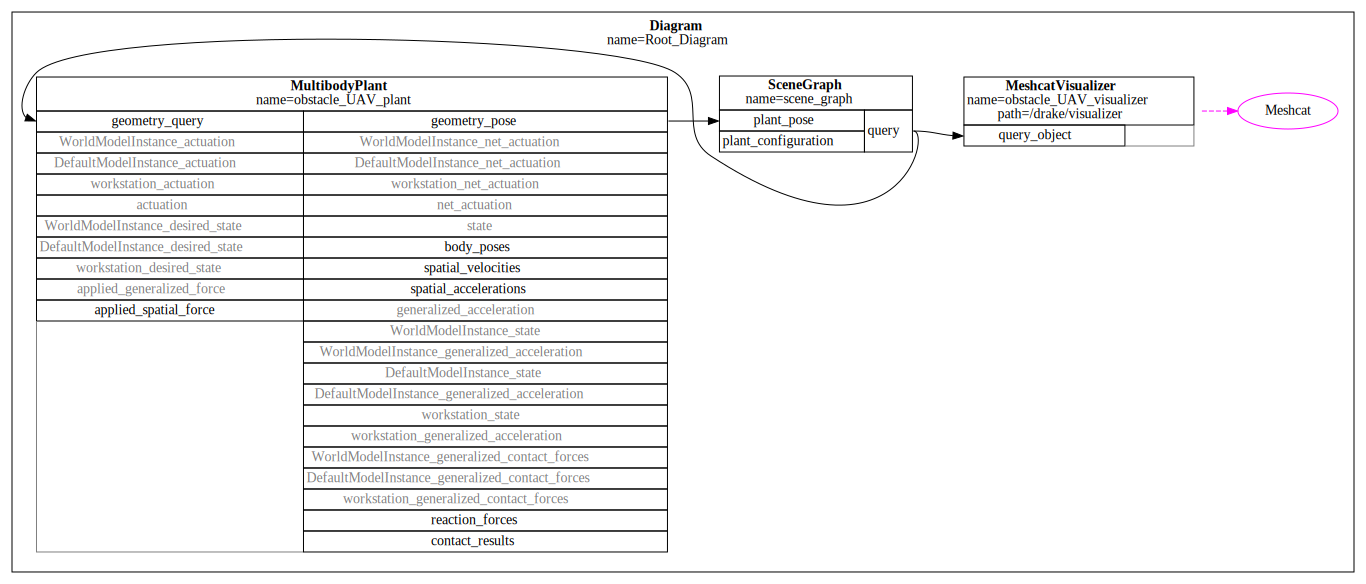

Model Instances and Bodies:

Model Instance: WorldModelInstance
  Body Name: world
Model Instance: DefaultModelInstance
Model Instance: workstation
  Body Name: ground
  Body Name: obs1
  Body Name: obs2
  Body Name: obs3
  Body Name: obs4
  Body Name: obs5
  Body Name: obs6
Number of model instances:  3
Number of bodies:  8



In [2]:
PATH_TO_OBSTACLE_ENV = "models/obstacles_house_formation.urdf"
simEnv = sim.SimulationEnvironment(obstacle_load_path=PATH_TO_OBSTACLE_ENV)
simEnv.connect_meshcat()
simEnv.build_model()
simEnv.save_and_display_diagram()
sim.print_model_instances(simEnv.plant)


In [3]:

# width of ground, lenght of ground,height of highest obstavle + 1. Look in urdf file
center_ground_xy = np.array([0, 5]) 
ground_width = 7
ground_length = 15
obst_height = 2

irisOptions = irisUtils.IrisWrapperOptions()
irisOptions.use_CliqueCover = False
irisOptions.seed = 0
irisOptions.region_file_path = "region_files/iris_regions_test"
irisOptions.clique_num_points = 1000
    
irisOptions.obstacle_offset_factor = 1.9
irisOptions.num_regions = 5

irisWrapper = irisUtils.IrisWrapper(irisOptions) 
simEnv.compute_obstacles(irisWrapper)
irisWrapper.determine_and_set_domain(center_ground_xy, ground_width, ground_length, obst_height)    
irisWrapper.randomGen = RandomGenerator(irisOptions.seed)
  
irisWrapper.add_meshVisualization_iris_obstacles(simEnv.meshcat, is_visible=True)
irisWrapper.add_meshVisualization_iris_domain(simEnv.meshcat, is_visible=True)
    

In [4]:
num_samples = 100
points = []

for i in range(num_samples):
    sample = irisWrapper.find_samplepoint_rand(prev_sample=None)
    points.append(sample)


isc.plot_points(simEnv.meshcat, points, "samplePoint")

Chosen point: [-0.33913765  8.16940804  0.29295427]
Chosen point: [-2.94810328  1.65621216  2.96870209]
Chosen point: [-1.95343829  4.92326596  0.36464343]
Chosen point: [-0.1191153  11.98806209  0.15111018]
Chosen point: [2.66208323 3.82980535 2.56572599]
Chosen point: [ 2.55864747 11.26813264  0.84395611]
Chosen point: [-2.46844447  0.95907782  2.49921866]
Chosen point: [3.26852325 8.5867238  2.76764789]
Chosen point: [0.24280857 4.89998441 1.12273375]
Chosen point: [-0.45950662 11.13606936  1.21327481]
Chosen point: [-2.09242846 10.90818855  1.99116026]
Chosen point: [-2.90765794  7.93683222  2.87459808]
Chosen point: [1.95037176 6.72993245 2.17627485]
Chosen point: [-1.86701348  4.56892291  1.80057963]
Chosen point: [ 2.48719071 11.18223063  2.36252106]
Chosen point: [1.98469208 9.44425066 2.70255798]
Chosen point: [-3.42902637  9.03778824  2.06063979]
Chosen point: [ 2.9502718  11.80608187  1.59136651]
Chosen point: [0.48721013 8.30996637 2.61305296]
Chosen point: [-2.5435595   8.

In [5]:
adj_mat = isc.vgraph(np.array(points), irisWrapper.iris_obstacles)

cliques = isc.compute_minimal_clique_partition_nx(adj_mat)

100%|███████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


In [6]:
points = np.array(points)
isc.plot_cliques(simEnv.meshcat, cliques, points,  "cliques")




In [7]:
cliquepts = [points[cl] for cl in cliques]



ells = [Hyperellipsoid.MinimumVolumeCircumscribedEllipsoid(clpt.T) for clpt in cliquepts]

In [8]:

regions = []
for e in ells:
    seed = e.center()
    options = pyOpt.IrisOptions()
    options.require_sample_point_is_contained = True
    options.starting_ellipse = e
    # options.random_seed = seed
    
    r = pyOpt.Iris(irisWrapper.iris_obstacles, seed, irisWrapper.domain, options)
    regions.append(r)
    


In [9]:
irisWrapper.iris_regions = regions

irisWrapper.add_meshVisualization_iris_regions(simEnv.meshcat, is_visible=True)

In [10]:

import pickle

try:
    
    save_reg_pth = "region_files/reg_clique.pkl"
    with open(save_reg_pth, 'wb') as f:
        pickle.dump((regions, points, cliques), f)
except Exception as e: 
    print(e)
    print("Error saving regions")
                

In [11]:
with open(save_reg_pth, 'rb') as f:
    reg, samples, cliques = pickle.load(f)
    
print(reg)
print(samples)
print(cliques)


[<pydrake.geometry.optimization.HPolyhedron object at 0x7f2d23b32370>, <pydrake.geometry.optimization.HPolyhedron object at 0x7f2d23ad23b0>, <pydrake.geometry.optimization.HPolyhedron object at 0x7f2d23b2dc30>, <pydrake.geometry.optimization.HPolyhedron object at 0x7f2d23ad2270>, <pydrake.geometry.optimization.HPolyhedron object at 0x7f2d23ad23f0>, <pydrake.geometry.optimization.HPolyhedron object at 0x7f2d23ad21f0>]
[[-3.39137646e-01  8.16940804e+00  2.92954265e-01]
 [-2.94810328e+00  1.65621216e+00  2.96870209e+00]
 [-1.95343829e+00  4.92326596e+00  3.64643426e-01]
 [-1.19115304e-01  1.19880621e+01  1.51110177e-01]
 [ 2.66208323e+00  3.82980535e+00  2.56572599e+00]
 [ 2.55864747e+00  1.12681326e+01  8.43956113e-01]
 [-2.46844447e+00  9.59077824e-01  2.49921866e+00]
 [ 3.26852325e+00  8.58672380e+00  2.76764789e+00]
 [ 2.42808565e-01  4.89998441e+00  1.12273375e+00]
 [-4.59506617e-01  1.11360694e+01  1.21327481e+00]
 [-2.09242846e+00  1.09081886e+01  1.99116026e+00]
 [-2.90765794e+00 

In [36]:
import GcsTrajectoryUtils as gcsUtils

options = gcsUtils.GCSTrajectoryOptions()
options.use_BezierGCS = False
options.regions = irisWrapper.iris_regions
options.path_continuity_order = 3 # 3 works
options.Bspline_order = 4   # 4 works
# options.edges = None
options.hdot_min = 1e-3
options.full_dim_overlap = True
options.traj_file_path = 'trajectory_files/trajectory'
options.derivative_regularization = 1e-3

gcsTraj = gcsUtils.GCSTrajectory(3, options)
start = [0, 0, 1]
# goal = [0.5, 11.5, 1.5]
goal = [0, 10.5, 1.5]

vel_lower_bound = np.ones(3) * -1
vel_upper_bound =  np.ones(3) * 1 #np.array([100000, 100000, 100000])



gcsTraj.add_start_goal_and_viz(start, goal, simEnv.meshcat, zero_deriv_boundary=1)
gcsTraj.add_pathLengthCost(0.5)
gcsTraj.add_timeCost(1)
gcsTraj.add_velocityBounds(vel_lower_bound, vel_upper_bound)
gcsTraj.add_continuityContraint()




adding C1 constraints
adding C2 constraints
adding C3 constraints


In [37]:

print(gcsTraj.USE_BEZIER)


val = gcsTraj.load_trajectory_from_file() 



False
Loading trajectory from file
Loading trajectory from file
Loading trajectory from file
Trajectory loaded from trajectory_files/trajectory.pkl


In [41]:
def save_trajectory_to_file():
    print("Saving trajectory to file")
    if gcsTraj.trajectory is None:
        print("Trajectory is not defined")
        return False

    path = gcsTraj.traj_file_path+".pkl"   
    try:
        with open(path, 'wb') as f:
            pickle.dump((gcsTraj.trajectory), f)
        print(f"Trajectory saved to {path}")
        return True

    except Exception as e:
        ## print error message:
        print(f"Failed to save trajectory to {path}")
        print(f"Error: {e}")
    return False

save_trajectory_to_file()

Saving trajectory to file
Trajectory saved to trajectory_files/trajectory.pkl


True

In [38]:
if val is None:
    gcsTraj.solve(preprocessing=False)   
    gcsTraj.save_trajectory_to_file()

In [42]:
num_points = 2000
gcsTraj.visualize_trajectory(simEnv.meshcat, num_points)

INFO:drake:Meshcat listening for connections at http://localhost:7004


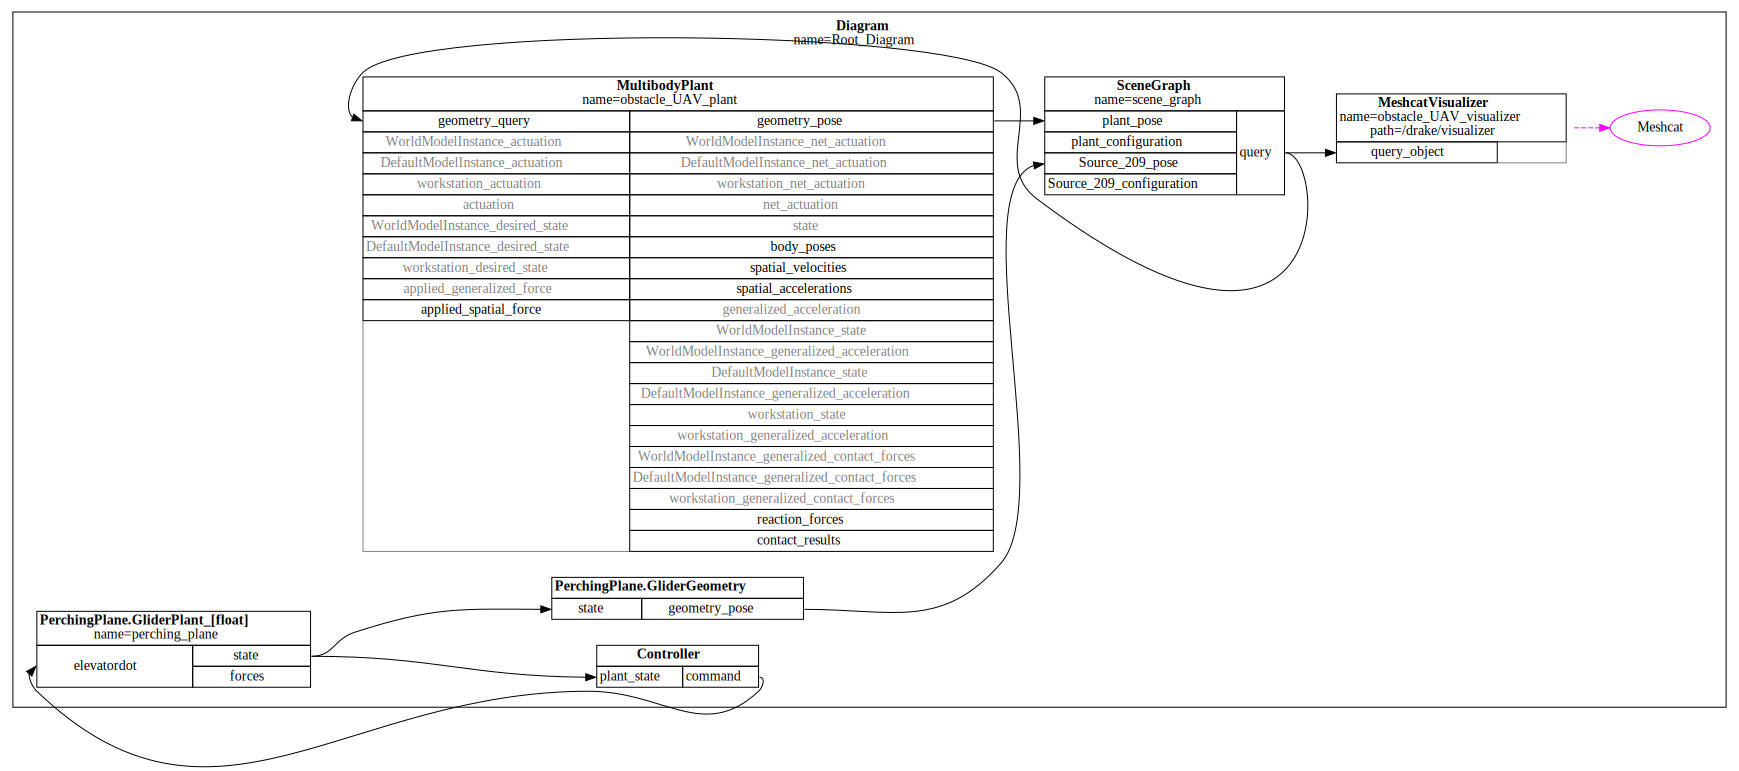

In [15]:
simulator = sim.SimulationEnvironment(PATH_TO_OBSTACLE_ENV)
simulator.connect_meshcat()
simulator.add_fixed_wing()
simulator.add_controller(gcsTraj.trajectory.value(6))
simulator.build_model()
simulator.save_and_display_diagram()


irisWrapper.add_meshVisualization_iris_regions(simulator.meshcat, is_visible=True) 
gcsTraj.visualize_start_goal(start, goal, simulator.meshcat)
gcsTraj.visualize_trajectory(simulator.meshcat, num_points)
irisWrapper.add_meshVisualization_iris_obstacles(simulator.meshcat, is_visible=False)
irisWrapper.add_meshVisualization_iris_domain(simulator.meshcat, is_visible=True)

simulator.simulate(5)